# Machine Learning in Python - Project 1

Due Friday, March 6th by 5 pm.

Lorenzo Wagemaker, Kyriacos Xanthos

## Introduction ##

In this report we aim to investigate and determine the features which make an episode of 'The Office' successful. We use the [`schrutepy`](https://pypi.org/project/schrutepy/) package for our investigations and we create a Machine Learning model that predicts the features that make an episode of 'The Office' have a high IMDb rating. Our goal is to give an insight into how these features can be used to create a successful reunion episode.

Our approach was first to vizualise the data, find potential correlations, use feature engineering techniques to enhance our dataset based on the correlations and use machine learning models to identify predictive outcomes. 

The feauture engineering of our dataset was very important to create a reliable model. Since there were a lot of directors and writers that had only directed or written just one episode, the dataset proved to be very noisy. We have included an analysis that gave us an insight into which features were important and had an impact on the rating on the episode, and used these features to predict success of episodes. We decided a Linear Regression Model was the most appropriate with our dataset, and this model can be used when a prospective episode is drafted to show its potential rating on IMDd. 


## Exploratory Data Analysis and Feature Engineering

Now we insert all packages needed for this analysis and set some default plot parameters that are used throughout the report. 

In [1]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

import warnings # supress warnings
warnings.filterwarnings('ignore')

All of the data is stored in the `the_office.csv` file which we import on the cell below.

In [2]:
d = pd.read_csv("the_office.csv")

At first we began by creating a pairplot with all of the numerical features of our data but it was very hard to spot any real correlations. Then we noticed that the number of total ratings per episode varied for a significantly as seen on the plot below.

<AxesSubplot:xlabel='total_votes', ylabel='Count'>

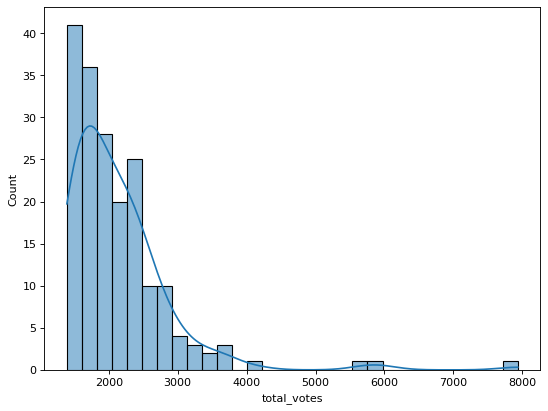

In [3]:
sns.histplot(d["total_votes"], kde=True, bins=30)

This made us scheptical about using the pure `imdb_rating` feature of our dataset as the success of an episode, and so we created a new weighted average depending on the number of ratings using a Bayesian approach. 

We have implemented a [Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) calculation for creating a new weighted rating we call `w`. The equation we use to calculate `w` is as follows:

$$ w = \frac{v}{v+m}  R + \frac{m}{v+m} C$$


where $v$ is the number of total votes (`total_votes`), $R$ is the IMDb rating (`imdb_rating`), $C$ is the average rating of all episodes and $m$ is the minumum number of votes for an episode to be included in our analysis. 

This is the same algorithm used by IMDb to list their top 250 titles ([link](https://www.quora.com/What-algorithm-does-IMDB-use-to-decide-the-top-250-movies)).



In [4]:
v = d['total_votes']
C = np.mean(d['imdb_rating'])
m = 1000
R = d['imdb_rating']

d['w'] = (v / (v+m)) * R + (m / (v+m)) * C

We then created two plots of the histograms of `imdb_rating` and `w` to check and see that we have a Gaussian distribution for both ratings.

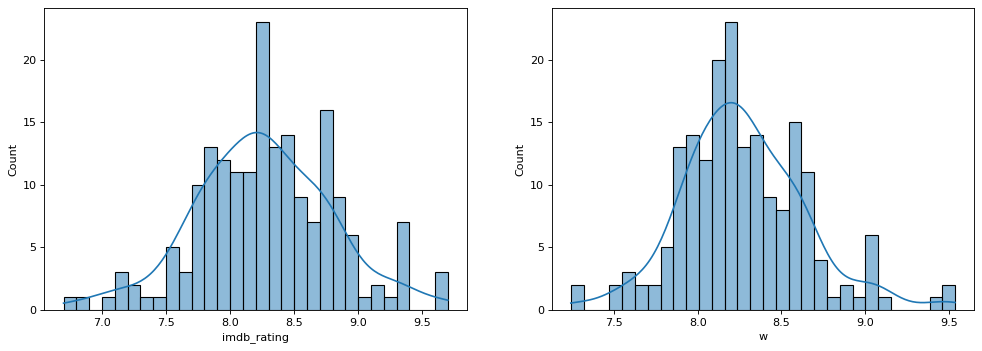

In [5]:
fig, ax =plt.subplots(1,2, figsize = (15,5))
sns.histplot(d["imdb_rating"], kde=True, bins=30 , ax =ax[0])
sns.histplot(d["w"], kde=True, bins=30, ax =ax[1])
fig.show()

From this point on, we use `w` as our dependent variable of measuring episode success. We store this variable in our dataframe in a new column as: `d['w']`.

In the cells below we summarise in a few plots the correlations we were able to extract from visualizing the data. We intentionally left out the `episode_name` and `air_date` since we don't believe they affected in any way the rating of the episode. 


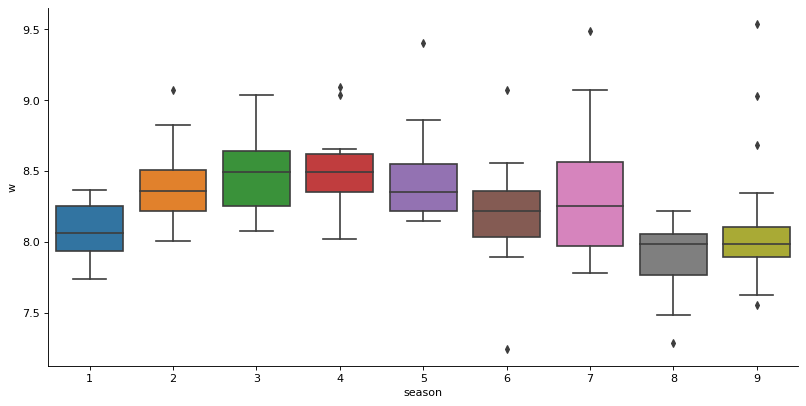

In [6]:
sns.catplot(
    y = "w",
    x = "season",
    data = d,
    aspect = 2,
    kind = 'box'
)

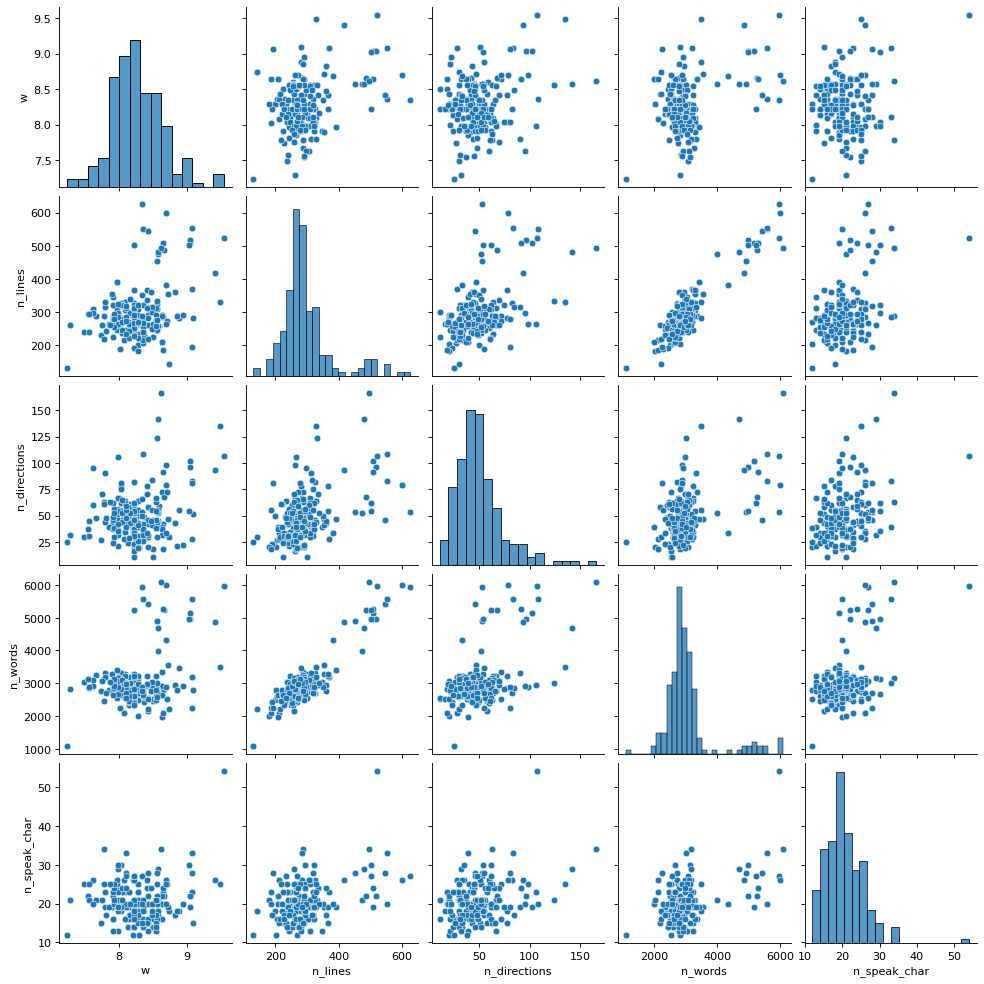

In [7]:
sns.pairplot(d,
    x_vars=["w", "n_lines", "n_directions", "n_words", "n_speak_char"],
    y_vars=["w", "n_lines", "n_directions", "n_words", "n_speak_char"],
)

The catplot shows that `w` has definetly increased for the first 4 seasons and experienced a steady decrease for the later 5 seasons including some uncertainty for season 7 and some clear outliers in season 9. 

The plots of `w` against `n_lines`, `n_words`, `n_speak_char` did not show any significant correlations, indicating that we might need to encode some specific characters with the number of lines, or specific directors with number of directions. 

Next, we wanted to convert our categorical variables (`director` , `writer`, `main_chars`) into a numeric representations that could be included in our model matrix. We have used an approach for transforming categorical variables known as [one hot encoding](https://en.wikipedia.org/wiki/One-hot). With this encoding all levels of the categorical variable are transformed into a new columns with values of 0 or 1. `scikit-learn` has its own implementation for this, but we have decided to create our own implementation (`create_dummies` function), because we wanted to seperate strings of multiple actors, directors and writers so as to have their own columns. The `create_dummies` function creates column names with a preceding`dir_` for directors, `wri_` for writers and `char_` for characters. For example a column name for director becomes: `dir_<name of director>`. The updated dataframe is shown below.


In [8]:
def create_dummies(col):
    # creates one-hot encoded variables
    def f(row):
        # if it is present in the row it returns 1
        if i in row[col]:
            val = 1
        else:
            val = 0
        return val

    all_chars =[]

    for lst in d[col]:
        # split string with multiple names
        for j in lst.split(';'):
            if j not in all_chars:
                all_chars.append(j)
    
    for i in all_chars:
        
        if col == 'director':
            j = str('dir_' + i)
            d[j] = d.apply(f, axis=1)
        elif col == 'writer':
            j = str('wri_' + i)
            d[j] = d.apply(f, axis=1)
        elif col == 'main_chars':
            j = str('char_' + i)
            d[j] = d.apply(f, axis=1)
    return all_chars
        
chars = create_dummies('main_chars')
directors = create_dummies('director')
writers = create_dummies('writer')


d.head()

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,...,wri_Amelie Gillette,wri_Allison Silverman,wri_Dan Greaney,wri_Owen Ellickson,wri_Jonathan Green,wri_Gabe Miller,wri_Dan Sterling,wri_Graham Wagner,wri_Nicki Schwartz-Wright,wri_Tim McAuliffe
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,...,0,0,0,0,0,0,0,0,0,0
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,...,0,0,0,0,0,0,0,0,0,0
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,...,0,0,0,0,0,0,0,0,0,0
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,...,0,0,0,0,0,0,0,0,0,0
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,...,0,0,0,0,0,0,0,0,0,0


The above encoding allowed us to inspect specific actors, directors and writers which yield high values of `w`.  Below we can see the top 5 directors, writers and characters that yield the highers `w`'s.

In [9]:
def get_means_type(typ, d = d):
    # finds the mean of w for each character, director and writer
    means = []
    if typ == directors:
        t = 'dir' 
    elif typ == writers:
        t = 'wri'
    elif typ == chars:
        t = 'char'
        
    for director in typ:
        new_df = d.loc[d['{}_{}'.format(t, director)] == 1]
        mean = new_df['w'].mean()
        means.append([director, mean, len(d.loc[d['{}_{}'.format(t, director)] == 1])])
    types = sorted(means,key=lambda l:l[1], reverse=True)
    return types

In [10]:
get_means_type(chars)[:5]

[['Michael', 8.374908475880064, 137],
 ['Kelly', 8.326574743059522, 142],
 ['Ryan', 8.294236584280753, 139],
 ['Creed', 8.288868004162985, 131],
 ['Stanley', 8.288420371614174, 165]]

In [11]:
get_means_type(directors)[:5]

[['Steve Carell', 8.612779704532336, 3],
 ['Harold Ramis', 8.608424507996016, 4],
 ['Paul Feig', 8.587902735604155, 14],
 ['Paul Lieerstein', 8.565470707694882, 1],
 ['Jason Reitman', 8.562344898379964, 2]]

In [12]:
get_means_type(writers)[:5]

[['Steve Carell', 8.67905664042544, 2],
 ['Greg Daniels', 8.639281993466975, 12],
 ['Michael Schur', 8.51051615508468, 10],
 ['Jon Vitti', 8.489700576033522, 2],
 ['Lester Lewis', 8.488486284356194, 2]]

The third column in the above arrays is the number of episodes each director/character/writer was part of. It is clear that for the Machine-Learning Model analysis we want to do in this report, we have to include as many data as possible, so we created the functions `get_counts_type` and `top3_df` in order to sort a new dataframe with descending number of appearances for each director/writer/character and then slice it to find the top 3 most frequent appearances.

In [13]:
def get_counts_type(typ, d = d):
    # creates a small dataframe with all of dir/wri/char with descending number of episodes
    
    if typ == directors:
        t = 'dir' 
    elif typ == writers:
        t = 'wri'
    elif typ == chars:
        t = 'char'
    
    # sorts the typ in descending order of episodes
    data = []
    for i, direct in enumerate(typ):
        data.append([str(direct), len(d.loc[d['{}_{}'.format(t, direct)] == 1])])
    df_all = pd.DataFrame(data, columns = [f'{t}', 'Number of Episodes'])
    df_all= df_all.sort_values('Number of Episodes', ascending =False)
    return df_all

def top3_df(df_all, typ):
    # creates a dataframe with the top 3 dir/writ/chars
    if typ == directors:
        t = 'dir' 
    elif typ == writers:
        t = 'wri'
    elif typ == chars:
        t = 'char'
        
    # creates a list of the top 3 directors
    top_typ_list = list(df_all[:3].values[:,0])
    top_typ_list = list(map(f'{t}_'.__add__,top_typ_list))
    
    top_3_typ_df = d.loc[lambda df: df['{}'.format(top_typ_list[0])] | \
                     df['{}'.format(top_typ_list[1])] | df['{}'.format(top_typ_list[2])] == 1]
    return top_3_typ_df, top_typ_list

def visualize_top(types):
    # creates violin plots for categorical data

    # initialize plot counter
    c = 1

    fig = plt.figure(figsize=(14,10))

    for x in types:
        plt.subplot(1, 3, c)
        plt.xlabel(x)
        sns.violinplot(x, y = 'w', data = d)
        c = c + 1

    plt.show()


Now we can inspect the average ratings of each director/writer/character more clearly. The `visualize_top` function allows us to visualize the ratings of the top three most frequent directors and writers.  Note that the `0` and `1` numbers indicate the presence or apsence respectively of a certain director/writer in an episode.

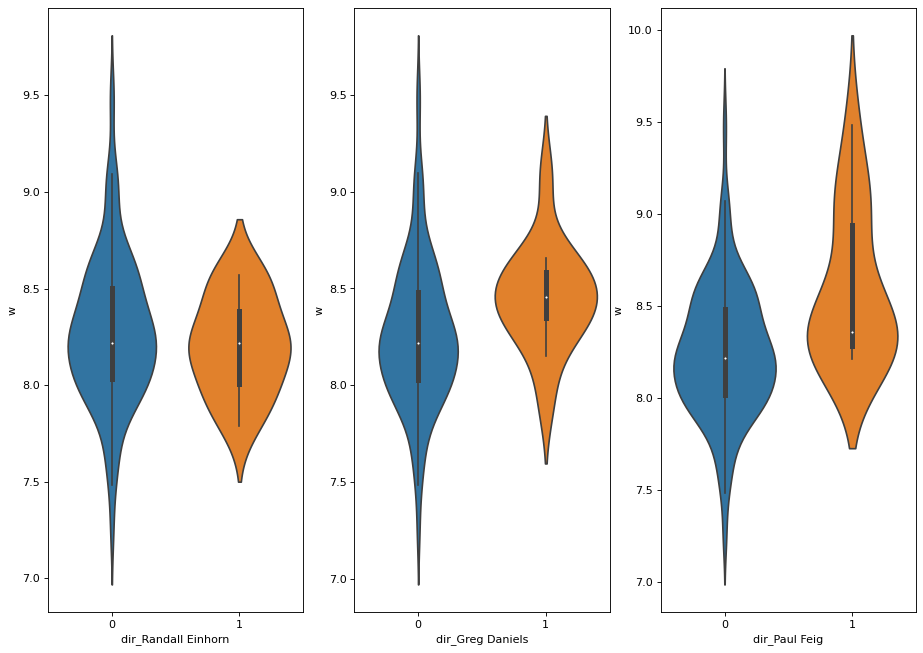

In [14]:
typ = directors
df_all = get_counts_type(typ)
top_3_typ_df, top_typ_list = top3_df(df_all, typ)
visualize_top(top_typ_list)

From the above violin plot it is clear that Paul Freig recieves the highest ratings in his episodes as the orange distribution of `w`'s is higher than the blue distribution. This is consistent with the arrays shown earlier with Paul Freig having an average rating of 8.59, the third amongst all of the directors. Of course since he has directed significantly more episodes than the other directors in the list it is a reliable conclusion from the above plot that he might be the best director in the series. This will be further explored in the Machine Learning Section.

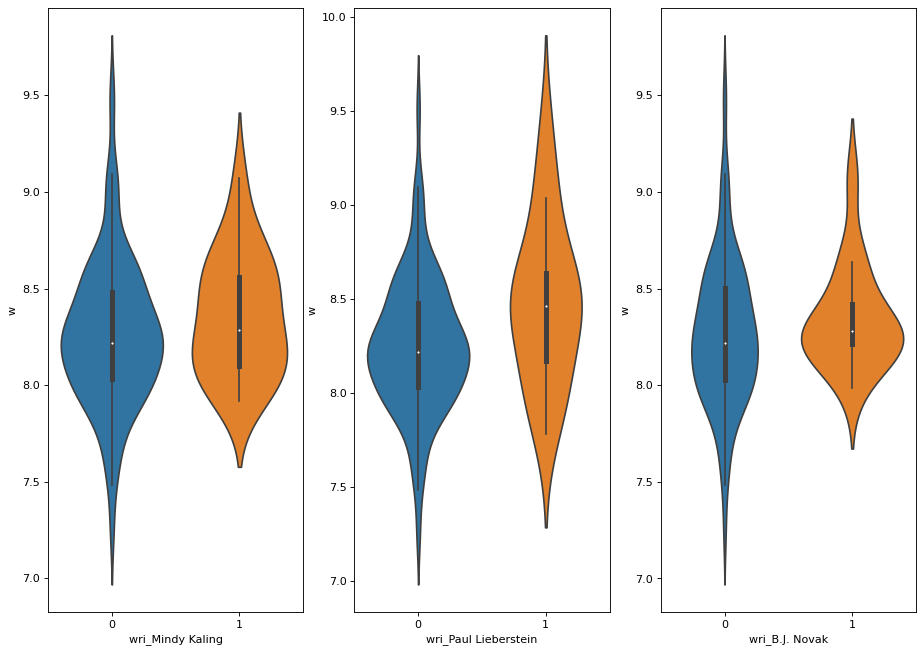

In [15]:
typ = writers
df_all = get_counts_type(typ)
top_3_typ_df, top_typ_list = top3_df(df_all, typ)
visualize_top(top_typ_list)

The violin plots for the writers do not show a clear distinnction between the top 3 writers, however it seems that B. J. Novak has the smallest distribution of ratings and it is skewed towards highest ratings than the other 2 writers. Although Paul Lieberstein has the potential to achieve the highest ratings out of the three, the distribtuion of his ratings is so large that we cannot qualitevely decide whether he is the best writer overall. We will explore this further in the Machine Learning Section.

Since most of the characters appear in all episodes we selectively checked some of the characters that are not present for all the episodes.

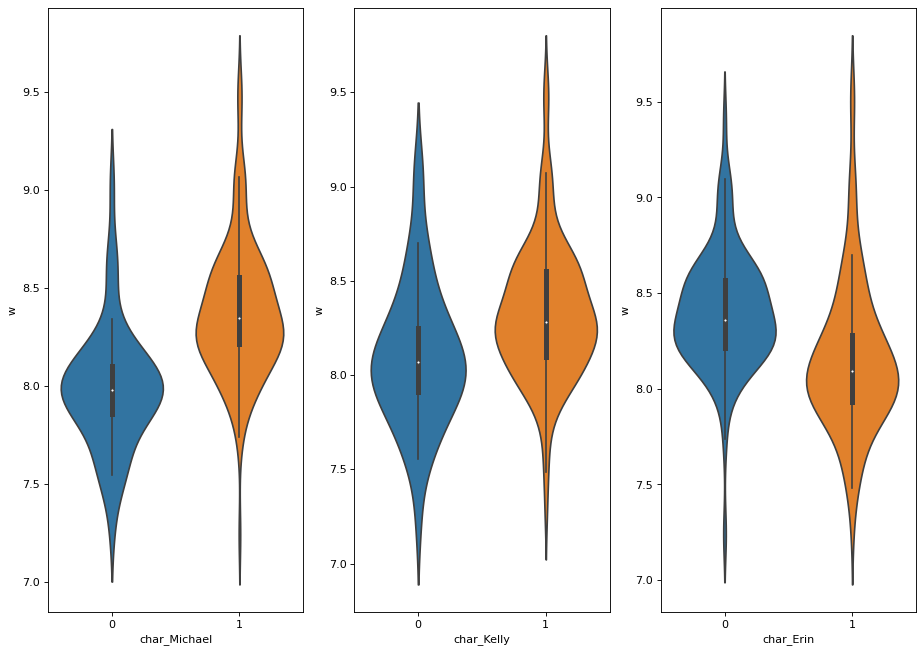

In [16]:
visualize_top(['char_Michael', 'char_Kelly', 'char_Erin'])

The above plot has some stricking results, since we can see there is a large deviation of the ratings with Michael in and out of the episode. It seems that an episode recieves a significantly higher rating on average when Michael is present. This is also true for Kelly however the difference in the distribution is not as stricking. The Show recieves lower ratings when Erin is in the episode but we are quite scheptical about this conclusion because she only appears in the Series in the later seasons which as shown from the catplot have lower ratings in general. 

The above analysis has given us some qualitative results and insights into the Office dataset. We have used feature Engineering to 'one-hot encode' our categorical variables which allowed us to explore each director, writer and character for the show seperately. Our visualization tools provided us with no concrete correlations between number of lines, number of words or number of stage directions but in the next section we try to check these parameters with specific features of an episode. Now we turn towards Machine Learning tools in order to try to find some predictive features towards episode success.

## Model Fitting and Tuning

Linear Regression Models are some of the most widely used models for Machine Learning. Intuitively they fit linear functions to data. A regression model can be represented using matrix notation and we can derive a solution using least squares. This is expressed as:
$$
\underset{\boldsymbol{\beta}}{\text{argmin}} \,\, \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2 
= \underset{\boldsymbol{\beta}}{\text{argmin}} \,\, (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta})^\top(\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta})
$$

where,

$$
\underset{n \times 1}{\boldsymbol{y}} = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_{n-1} \\ y_n \end{pmatrix} 
\qquad
\underset{n \times 2}{\boldsymbol{X}} = \begin{pmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_{n-1} \\ 1 & x_n \\ \end{pmatrix}
\qquad 
\underset{2 \times 1}{\boldsymbol{\beta}} = \begin{pmatrix} \beta_0 \\ \beta_1 \end{pmatrix}
$$

The main task of a model is to solve the optimization problem: 

$$
\boldsymbol{\beta} = \left(\boldsymbol{X}^\top\boldsymbol{X}\right)^{-1} \boldsymbol{X}^\top\boldsymbol{y}
$$

In the Office dataset we let $\boldsymbol{y}$ = `w` and $\boldsymbol{X}$ a matrix the the features we want to test. 

We will be using the scikit-learn (sklearn) library to implement most of our regression models. Specifically for the linear regression model we use the `LinearRegression` model from the `linear_model` submodule.

We also note that another important part of creating a reliable model is to never use training data to test the predicitveness for our model. For this reason we use cross validation for the purpose of model evaluation and selection. We split the data into a testing and training set, using  the `train_test_split` from the `model_selection` submodule of `scikit-learn`. We chose a test size of 25% since the data we had was not enough to have a smaller test size.

We assess the models' performance using root mean squared error, 

$$ 
\text{RMSE} = \left( \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 \right)^{1/2} 
$$

where $y_i$ are the true values of the model and $\hat{y}$ the predicted ones. With sklearn this is calculated using the `mean_squared_error` function with the argument `squared=False`. This metric is entirely equivalent to mean squared error for purposes of ranking models.



The two functions defined below will serve as helper functions for evaluating the success of our models.

In [17]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = mean_squared_error(y, y_hat, squared=False)
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

Now, before we go any further with Linear regressions we fit a baseline model which we will be able to use as a point of comparison for our subsequent models. We will do this by using a simple linear regression model that includes all of our non-categorical features.

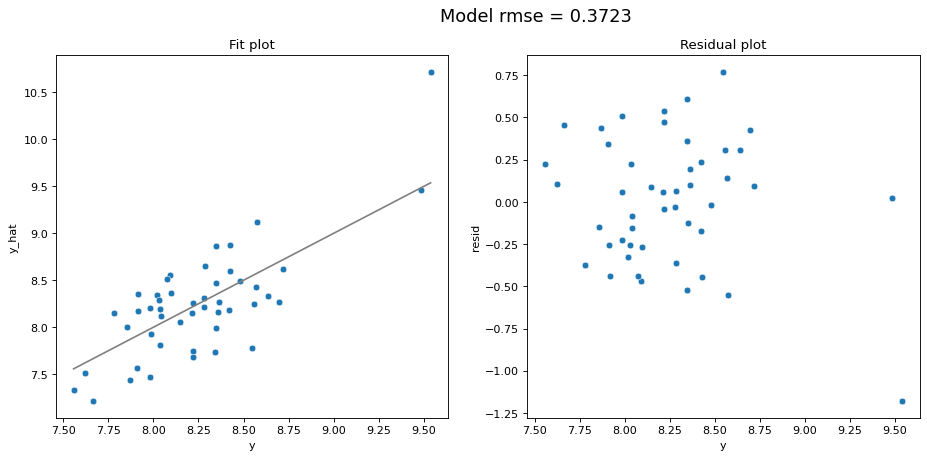

0.3722864268273774

In [18]:
# Prepares the dependent and independent variables
X = d.drop(['season','episode','director','writer','air_date','episode_name','main_chars','imdb_rating','w'], axis=1)
y = d['w']

# Splits into training/testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Fits linear regression model
lm = LinearRegression().fit(X_train, y_train)

model_fit(lm, X_test, y_test, plot=True)

This shows that when simply using all features we get an rmse of 0.3723. This is fairly decent, but as we go further into this section we will try to tune this model to achieve an optimal rmse. Before moving on to apply such models though, we fitted a simple linear regression model to find which features correlated well with `w`. For instance, following the visualizations in the previous section we investigated whether the presence of Michael affected the rating.

<AxesSubplot:xlabel='season', ylabel='w'>

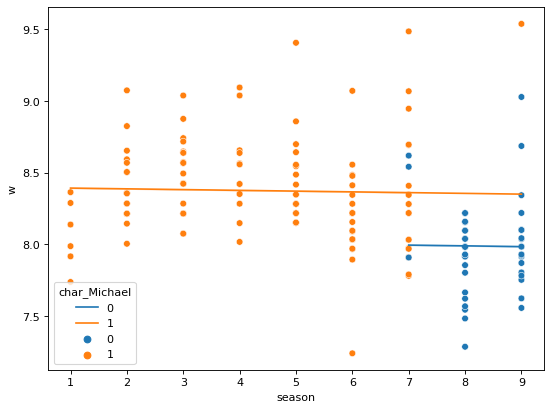

In [19]:
# Fits a linear regression model to the data
y = np.array(d.w)
X = np.c_[np.ones(len(y)), d.season, d['char_Michael']]
l = LinearRegression(fit_intercept=False).fit(X, d.w)

beta = l.coef_

d['char_Michael_pred'] = l.predict(X)
sns.scatterplot(x="season", y="w", hue="char_Michael", data=d)
sns.lineplot(x="season", y="char_Michael_pred", hue="char_Michael", data=d)


According to the above linear regression diagram, it is clear that the predicted rating `w` clearly decreases in the last couple seasons (where `char_Michael` = 0). This is a clear initial indication that having Michael in the episodes bodes well for the rating. It was expected such a relation would be found in the linear regression as the decision tree done above seemed to imply some correlation between Michael and episode ratings was present.

Such relationships were found for many more features in the data, hence begging the questions which features should be included in our model.

To figure out what features should be used in the linear regression model we used a method known as RFE (Feature ranking with recursive feature elimination). RFE is used to assign weights to features (e.g., the coefficients of a linear model) and decide what features are most important. RFE does this through recursively considering smaller and smaller sets of features. First, we train the estimator on the initial set of features from which the importance of each feature is  obtained. Then, the features it finds less important are removed from current set of features. This is then repeated until the required number of features is obtained. 

We apply now this RFE method to a reduced version of the data set and see what features it finds most important. We begin by limiting the data set to significant writers/directors (appearing more than 12 times in the data set) and removing categorical data that has been included through hot encoding. We remove the directors/writers with limited credits as their data would be highly random and contribute little to an accurate prediction model.

In [20]:
# Creates a copy of the data frame to change without affecting the original
d_copy = d.copy()
d_copy.drop(['char_Michael_pred','season','episode','episode_name',
'director','writer','imdb_rating','total_votes','air_date','main_chars'], axis = 1, inplace = True)

d_copy.drop([col for col, val in d_copy.sum().iteritems() if val < 13], axis=1, inplace=True)

# Creates the training/testing sets
X = d_copy.drop(['w'],axis=1)
y = d_copy['w']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fits a linear regression model to the training data
lm = LinearRegression()
lm.fit(X_train, y_train)

# Applies RFE to the training data
rfe = RFE(lm, n_features_to_select=1)             
rfe = rfe.fit(X_train, y_train)

# tuples of (feature name, whether selected, ranking)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))


[('n_lines', False, 24),
 ('n_directions', False, 27),
 ('n_words', False, 28),
 ('n_speak_char', False, 21),
 ('char_Angela', False, 17),
 ('char_Dwight', False, 29),
 ('char_Jim', True, 1),
 ('char_Kevin', False, 12),
 ('char_Michael', False, 2),
 ('char_Oscar', False, 16),
 ('char_Pam', False, 18),
 ('char_Phyllis', False, 9),
 ('char_Ryan', False, 15),
 ('char_Stanley', False, 23),
 ('char_Kelly', False, 14),
 ('char_Toby', False, 13),
 ('char_Meredith', False, 11),
 ('char_Darryl', False, 20),
 ('char_Creed', False, 19),
 ('char_Andy', False, 7),
 ('char_Erin', False, 6),
 ('dir_Greg Daniels', False, 5),
 ('dir_Paul Feig', False, 4),
 ('dir_Randall Einhorn', False, 8),
 ('wri_B.J. Novak', False, 22),
 ('wri_Paul Lieberstein', False, 3),
 ('wri_Mindy Kaling', False, 10),
 ('wri_Gene Stupnitsky', False, 26),
 ('wri_Lee Eisenberg', False, 25)]

To apply the RFE above we begin by calling a `LinearRegression` model on the training data and then supply this data to the `RFE` method for assigning weights to the features. The importance of a feature is indicated by its closeness to 1 in the tuple. For instance ('char_Jim',True,1) indicates the RFE method has deemed Jim has a very useful feature for the linear regression. For this reason (and the above) only `char_Jim` and `char_Micael` will be left in the data set when we look for the best features as the other characters seem unimportant.

Now, before we proceed to using linear regression on the data set we will begin by using cross-validation and grid-search to tune the number of features hyper-paramater. This is important becuase we do not want to overfit the data set. 

We begin by limiting the data set to the characters we have shown have some correlation with `w`, i.e. `Michael` and `Jim`.

In [21]:
# Drops chars that have little/no correlation with w
d_copy.drop(['char_Angela','char_Dwight','char_Kevin','char_Oscar',
'char_Pam','char_Phyllis','char_Ryan','char_Stanley','char_Kelly',
'char_Toby','char_Meredith','char_Darryl','char_Creed','char_Andy','char_Erin'], axis = 1, inplace = True)

Let's see what kind of rmses we get when we apply these methods with all the data still left in the dataframe.

In [22]:
# k-fold CV (using all the features)
# Sets training/testing sets
X = d_copy.drop(['w'],axis=1)
y = d_copy['w']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fits Linear Regression model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Applies cross folds and gridsearch to find r sqaured score
folds = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores   

array([0.20542267, 0.15594078, 0.26073595, 0.2377839 , 0.34315895])

Now in the above cell we have started using the `KFold` method mentioned above. The main purpose of this method is to split the data into multiple train/test sets. For instance above we set `n_splits=5` meaning we divide the data into 25 sections where 5 are used for the testing of the data and the others are used for training the data. We use this method as it generally results in a less biased estimate of the model skill than simply using a train/test split. Now, the squared values we obtain indicate that the linear regression line is possibly a good fit for the data. It is possible, however, that the data is being overfit. We will now use Grid Search Cross-Validation to figure out the right number of features and then use sklearn ranking with recursive feature elimination to decide what these features are. We begin by simply using RFE as above to see the features left in the data set and their importance.

In [23]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=3

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=3)             
rfe = rfe.fit(X_train, y_train)

# tuples of (feature name, whether selected, ranking)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('n_lines', False, 10),
 ('n_directions', False, 11),
 ('n_words', False, 12),
 ('n_speak_char', False, 9),
 ('char_Jim', True, 1),
 ('char_Michael', True, 1),
 ('dir_Greg Daniels', False, 3),
 ('dir_Paul Feig', False, 2),
 ('dir_Randall Einhorn', False, 4),
 ('wri_B.J. Novak', False, 7),
 ('wri_Paul Lieberstein', True, 1),
 ('wri_Mindy Kaling', False, 5),
 ('wri_Gene Stupnitsky', False, 6),
 ('wri_Lee Eisenberg', False, 8)]

Now, we can use the `n_features_to_select=5` to limit the features to 5 and see what rmse the model would obtain with just those 5 features:

In [24]:
# predict w of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.23727843710707897


This `r2` is worse than some of the `r2` calculated above with all the features, possibly indicating the model responds better to more features being included. We now use cross-validation and grid search to determine the optimal number of features to maximise `r2`.

In [25]:
# Seperated the data into 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# Sets the hyper-paramters i.e. the number of features
hyper_params = [{'n_features_to_select': list(range(1, 15))}]

# Fits a linear regression model to the data
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# Uses girs search to evaluate r2 for each hyper-parameter
model_cv = GridSearchCV(estimator = rfe, param_grid = hyper_params, scoring= 'r2', cv = folds, verbose = 1,return_train_score=True) 


# fit the model
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14]}],
             return_train_score=True, scoring='r2', verbose=1)

In the code above we again use `RFE` and `KFold` to determine the weights of the features and split the data respectively. However, we now use the `GirdSearchCV` method to determine what value for `n_features_to_select` is optimal. In this instance `GirdSearchCV` calculates for each value in the `n_features_to_select` what the `r2` value is. This value indicates the percentage of variance in the dependent variable that the independent variables explain as a whole. This thus in effect shows how good the linear regression fit is. 

In [26]:
# Sets the data from gridsearch into a dataframe
cv_results = pd.DataFrame(model_cv.cv_results_)

We then fit the data from the `GridSearchCV` to a data frame so that the results can be graphed.

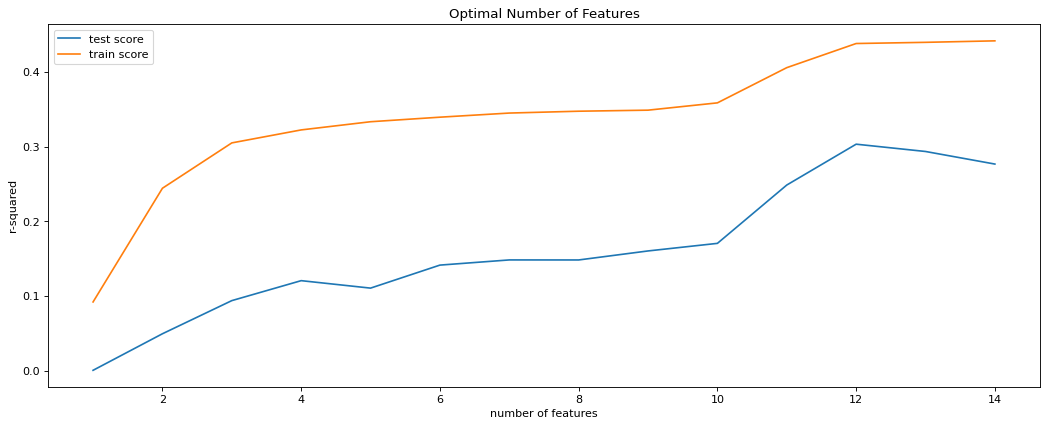

In [27]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

The graph above then shows the `r2` value that each `KFold` had on average for each of the different number of features. According to this graph the `r2` value peaks at 12 features hence that is the value that should be used for `n_features_to_select`. Moreover, we can see that when using 12 features we have a `r2` score of around 0.30, which is fairly high conisdering the data is not overly correlated. We now use `RFE` to determine what these 12 features should be:


In [28]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=12

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=12)             
rfe = rfe.fit(X_train, y_train)

# tuples of (feature name, whether selected, ranking)
list_of_features = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
list_of_features

[('n_lines', True, 1),
 ('n_directions', False, 2),
 ('n_words', False, 3),
 ('n_speak_char', True, 1),
 ('char_Jim', True, 1),
 ('char_Michael', True, 1),
 ('dir_Greg Daniels', True, 1),
 ('dir_Paul Feig', True, 1),
 ('dir_Randall Einhorn', True, 1),
 ('wri_B.J. Novak', True, 1),
 ('wri_Paul Lieberstein', True, 1),
 ('wri_Mindy Kaling', True, 1),
 ('wri_Gene Stupnitsky', True, 1),
 ('wri_Lee Eisenberg', True, 1)]

We now extract the true values of our array in order to use them as features in our matrix. The list `useful_features`  contains all of the variables that are going to be fed in our $\boldsymbol{X}$ matrix.


In [29]:
list_1 = [item for item in list_of_features if item[1] == True]

useful_features = []

for i in list_1:
    useful_features.append(i[0])

The equation to be solved will be of the form:


$\boldsymbol{y} = \boldsymbol{X} \boldsymbol{\beta}$
where $\boldsymbol{X} = \big[\boldsymbol{n_{lines}},\boldsymbol{n_{speak\_char}},  \boldsymbol{\mathbb{1}_{Jim}},  \boldsymbol{\mathbb{1}_{Michael}}, \boldsymbol{\mathbb{1}_{Greg}},  \boldsymbol{\mathbb{1}_{dir\_Paul}},  \boldsymbol{\mathbb{1}_{Randall}},  \boldsymbol{\mathbb{1}_{wri\_Paul}},  \boldsymbol{\mathbb{1}_{Mindy}}, \boldsymbol{\mathbb{1}_{Gene}}, \boldsymbol{\mathbb{1}_{Lee}} \big]$.

Each of the identities in $\boldsymbol{X}$ becomes 1 when the character/director/writer is in the episode and 0 otherwise. The non-categorical features, namely, `n_lines` and `n_speak_char`, will serve as our independent variables in the model.

The dependent variable $\boldsymbol{y}$ is `w`, and our model will try to predict `w` given the matrix $\boldsymbol{X}$. 


In [30]:
y = d['w']
X = d[useful_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [31]:
X.shape

(186, 12)

We first began by creating a simple Linear regression model but we decided a more reliable way of calculating a reliable error is by iterating through folds and comparing the RMSE for each one of them. We use the `GridSearchCV` function again from the `model_selection` submodule. We use 5 folds since our dataset only consists of 186 episodes, and we name our model `grid_search`. We also use a pipeline function `make_pipeline` from `sklearn` which allows us to create a general model with any kind of regressions and validations. In this pipeline apart from the linear regression we add a `Standard Scaler` which standardizes features by removing the mean and scaling to unit variance.


On the plot below we include the RMSE of our model a plot of the predicted and true values of `w` and the distribution of residuals against `w`.  Note that for these predictions we only use the testing set.


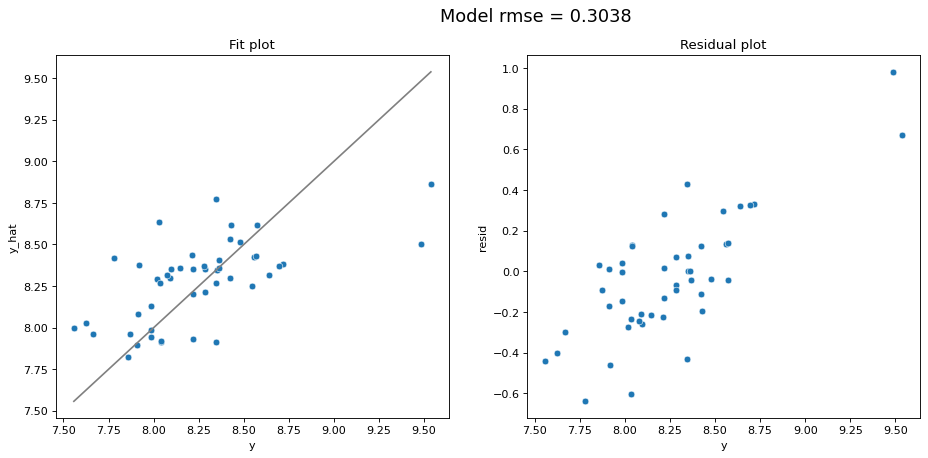

0.3037599038616419

In [32]:
grid_search = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        LinearRegression()
    ),
    param_grid = {},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(
    X_train, y_train
)

model_fit(grid_search, X_test, y_test, plot = True)

We can immediately see that the linear regression model was able to somewhat predict the rating of an episode with rmse 0.3038. Intuitively, this means that given an episode with parameters of the `useful_features` list, it will be able to predict its `w` rating with an accuracy of $\pm$ 0.3038. We believe that given the uncorrolation of the initial results, a prediction of this accuracy is interesting. The residual plot shows that there is a slight correlation between the residuals but not to an extend that we need to disregard the model.

At this point we need to mention that we have also tried three other regression models, namely Ridge regression, Lasso regression and decision tree regression. The first two regression models are similar to the Linear one, but they include a penalty term in their $y_i$ equation that shrinks the uncorelated results to almost zero. The Decision tree regression is slightly different as will be explained below. These rejected models are as follows:

- Ridge optimization problem:

Ridge regression is a natural extension to linear regression introducing an $\ell_2$ penalty on the coefficients to a standard least squares problem. This is translated as the  optimization problem,

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2 + \alpha (\boldsymbol{\beta}^T\boldsymbol{\beta}) $$ 

The `Ridge` model is provided by the `linear_model` submodule and requires a single parameter `alpha` which determines the tuning parameter that adjusts the weight of the $\ell_2$ penalty.

- Lasso optimization problem:

The Lasso is similar to Ridge regression, but instead uses an $\ell_1$ penalty on the coefficients. This is translated as the optimization problem,

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert_2^2 + \alpha \lVert \boldsymbol{\beta} \rVert_1 $$ 

As with the other models from this worksheet, the `Lasso` model is also provided by the `linear_model` submodule and similarly requires the choice of the tuning parameter `alpha` to determine the weight of the $\ell_1$ penalty.

We employed these two models again using Cross-Validation (`RidgeCV`for Ridge and `GridSearchCV` for Lasso) with 5 folds.

- Decision tree regression:

We also applied a Decision tree to the regression problems, using the `DecisionTreeRegressor` class. Decision trees can be used as predictive models that use a set of rules to calculate a target value, `w` in this case. A regression tree produces such an estimate by setting certain conditions on the data, each condition narrowing the possible values until the model gets confident enough to make a prediction. Each of the conditions are True/False questions that narrow down the data. The tree is then fitted on a test section of the data and the rmse calculated.



The table below shows the results we had for all 3 models using the same dataset :

| Regression         | RMSE      |
| -----------        | --------- |
| Linear             | 0.3028    |
| Ridge              | 0.3125    |
| Lasso              | 0.3327    |
| Tree               | 0.3112    |

The Linear regression had the best RMSE score and the distribution of $\boldsymbol{y}$ and $\boldsymbol{\hat{y}}$ was qualitatively better, which was why we decided to use it as our main model. This was somewhat expected, since the cross-validation used above to outline the best features of our inputs was aimed at a linear regression model.

After some extensive analysis on our linear regression model, we noticed that the last two episodes served as outliers of our dataset. They had higher ratings than almost any of the other episodes with no real stricking features. We could interpret that as the show ending was succesful, and this did not necessarily reflect the extreme success of a single episode, rather the overall happiness of viewers with the whole TV show and its succesful ending.

This allowed us to try and remove the last two episodes from our dataset to check if our model performed better:

In [33]:
d_reduced = d[:-2]

y = d_reduced['w']
X = d_reduced[useful_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

X.shape


(184, 12)

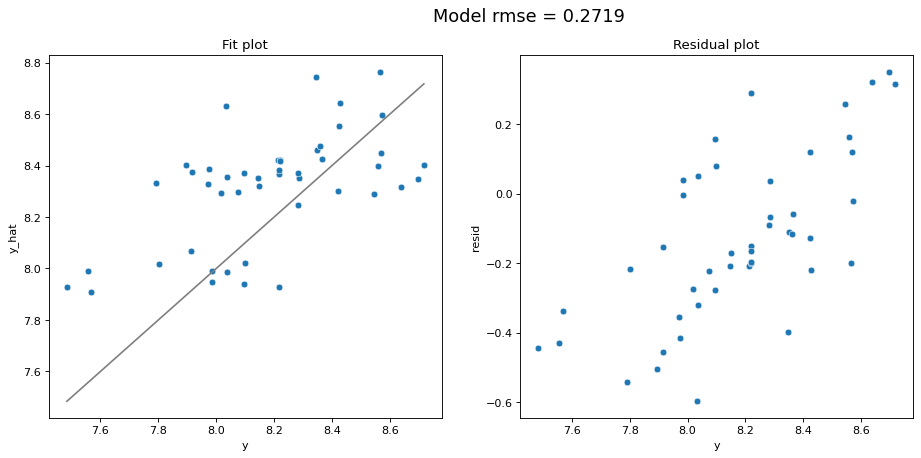

0.2719480085536659

In [34]:
grid_search = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        LinearRegression()
    ),
    param_grid = {},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(
    X_train, y_train
)

model_fit(grid_search, X_test, y_test, plot = True)

As we can see this change had a significant impact on both the model RMSE which was reduced to 0.2719 and the qualitative fit of the model.

## Discussion & Conclusions


### Usage 
We advice our client to use our model in two different ways. The first, before deciding the parameters of the episode to try a sample of combinations and see which of the combinations creates the highest value of `w`. We are confident that the model will predict the rating within $\pm0.3$ given there are no extreme changes in how the Show operates. An example of iterating through different combiations of characters/directors/writers, number of lines and speaking characters is shown below:

In [35]:
df_empty = X[0:0]
# initiate a list of different number of lines and speaking characters
lines_list = np.linspace(200, 501, 10)
speak_char_list = np.linspace(15, 30, 10)

# populate with some sample values
for n, (i, j) in enumerate(zip(lines_list, speak_char_list)):
    df_empty.loc[n] = pd.Series({'n_lines':int(i), 'n_speak_char':int(j)})
    

temp = df_empty.loc[:, 'char_Jim':]
# random directors writers and characters in episodes
categorical_data = pd.DataFrame(np.random.randint(0,2, size = temp.shape), columns=temp.columns, index=temp.index)
non_categorical_data = df_empty[['n_lines', 'n_speak_char']]
sample_test = pd.concat([non_categorical_data, categorical_data], sort=False, axis = 1)

`sample_test` is a sample dataframe with multiple different combinations. The client can alter this list, or create one of their own. The predicted rating for each row is shown as a new column `'w_pred'` in the sample_test dataframe.

In [36]:
sample_test['w_pred'] = grid_search.predict(sample_test)
sample_test

,n_lines,n_speak_char,char_Jim,char_Michael,dir_Greg Daniels,dir_Paul Feig,dir_Randall Einhorn,wri_B.J. Novak,wri_Paul Lieberstein,wri_Mindy Kaling,wri_Gene Stupnitsky,wri_Lee Eisenberg,w_pred
0,200.0,15.0,1,1,1,0,0,1,1,1,0,0,8.653975
1,233.0,16.0,0,0,1,1,0,0,1,1,1,0,7.601442
2,266.0,18.0,0,0,0,0,0,1,1,1,0,0,7.325702
3,300.0,20.0,0,1,0,1,1,1,1,1,0,1,7.945245
4,333.0,21.0,0,0,1,0,0,1,1,0,1,1,7.637132
5,367.0,23.0,1,0,1,0,1,1,1,0,0,0,8.467080
6,400.0,25.0,0,1,0,1,0,0,1,1,1,0,8.047016
7,434.0,26.0,1,0,0,1,1,0,0,0,1,1,8.379750
8,467.0,28.0,1,1,0,0,0,1,0,1,1,0,8.684541
9,501.0,30.0,0,0,0,0,0,0,0,0,1,0,7.406278


The second way a client could use our program would be after most of the features of the episode have been decided and the client wants to check the outcome of such an episode and alter some parameters to see how the rating changes. An example of a successful episode with a rating of 9+ is shown below. 

In [37]:
df_trial = X[0:0]
df_trial.loc[0] = pd.Series({'n_lines':500, 
                             'n_speak_char':27,
                             'char_Jim': 1,
                             'char_Michael': 1,
                             'dir_Greg Daniels': 1,
                             'dir_Paul Feig': 1,
                             'dir_Randall Einhorn': 0,
                             'wri_B.J. Novak': 1,
                             'wri_Mindy Kaling': 0,
                             'wri_Lee Eisenberg': 0,
                             'wri_Gene Stupnitsky': 0,
                             'wri_Paul Lieberstein': 0
                            })
print(f'Predicted w rating: {grid_search.predict(df_trial)[0]}')

Predicted w rating: 9.016695759192109


This allows us to conclude that a suggestion for a reunion episode follows the above features. Namely, add a large number of spoken lines (~500), with ~27 number of different characters with spoken lines, include both Michael and Jim in the episode, use both directors Greg Daniels and Paul Feig and make B.J. Novak the writer of the episode. Note that we do not have any particular recomendations for any of the other provided features like number of lines containing stage direction or number of words. This is because our model does not employ these parameters and we cannot give reliable predictions. 

## Conclusion

Our analysis has proved it was very difficult to find clear correlations and manage to predict accurately the features which make a successful episode of The Office. The main reason for that was that the dataset only consisted of 186 episodes which makes it really hard to remove the noise. Most of the directors and writers appeared in less than 3 episodes which created most of the noise in our dataset. Moreover, since the majority of the characters seemed to have no correlation at all with `w` it was only possible to include `Michael` and `Jim` in our model. Hence a lot of the data is ignored from an already small data set.

The way we suggest the client to use our model is to create a sample script of the reunion episode and feed the data into  the model we have trained. The client could potentially create a list of different directors and see which of the directors achieves the best score for `w`, as showed in the *Usage* section. The features which have were shown not to have a correlation with `w` can be included following the wishes of the directors/writers. For instance, any character outside of `Michael` or `Jim` could be included without much worry of the `w` score being affected.

One extension of the model would be to extend the dataset to include the transcripts of all the episodes with which we could differentiate and see how many number of lines each character had in an episode. This would allow us to find more clear correlations with the succeess of a specific character in the show.

Although our model predicts the rating with an accuracy of $\pm0.27$, we note that there might be other parameters that affect the rating of the episode more significantly than the ones we consider in this analysis. One natural example would be the plot of the episode, since that could have as a significant impact as any of the other parameters we explore. Another example could be the interaction between the characters on screen. However, with the dataset we were given, we are confident that our model would be able to give a useful insight with deciding some details of the Reunion episode, that could have an impact on the audience's experience. 

## 5. Convert Document

In [40]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf The_Office_Reunion.ipynb

[NbConvertApp] Converting notebook The_Office_Reunion.ipynb to pdf
[NbConvertApp] Support files will be in The_Office_Reunion_files/
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Making directory ./The_Office_Reunion_files
[NbConvertApp] Writing 125034 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7f438287-d619-4972-92d8-ee1c4d1c2e07' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>